In [1]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
from laos_gggi import load_emdat_data
from laos_gggi.plotting import plot_descriptive, _plot_single_kde, subplots_function, subplots_function_regions
from laos_gggi.const_vars import EM_DAT_COL_DICT, DISASTERS_FOUND, INTENSITY_COLS, EM_DAT_COL_DICT, PROB_COLS, REGIONS
from laos_gggi.statistics import descriptive_stats_function

# 0. Importing data

In [3]:
data = load_emdat_data()

em_dat_raw = data["df_raw"]

probability_df_filtered= data["df_prob_filtered"] 
intensity_df_filtered= data["df_inten_filtered"]

probability_df_filtered_adj= data["df_prob_filtered_adjusted"] 
intensity_df_filtered_adj= data["df_inten_filtered_adjusted"]

probability_df_unfiltered = data["df_prob_unfiltered"]
intensity_df_unfiltered = data["df_inten_unfiltered"]

em_dat_raw_filtered = data["df_raw_filtered"]   
em_dat_raw_filtered_adjusted = data["df_raw_filtered_adj"]  

# 1. Helper functions

In [4]:
#Data Columns
intensity_cols = intensity_df_filtered.describe().columns.to_list()
probability_cols = probability_df_filtered.describe().columns.to_list()

# 2. Effects of the filters

For the analysis only the events that satisfy the next criteria were considered:
- Start_Year > 1970
- Total_Affected > 1000
- Deaths > 100
  
These criteria follow the ones used by López, Thomas and Troncoso (2015).

Additionally, we consider only the next type of disasters:
"Drought", "Earthquake", "Extreme temperature", "Flood", "Storm", "Volcanic activity", "Wildfire".

When appliying the filters, the number of events in Laos is reduced from 47 to 1


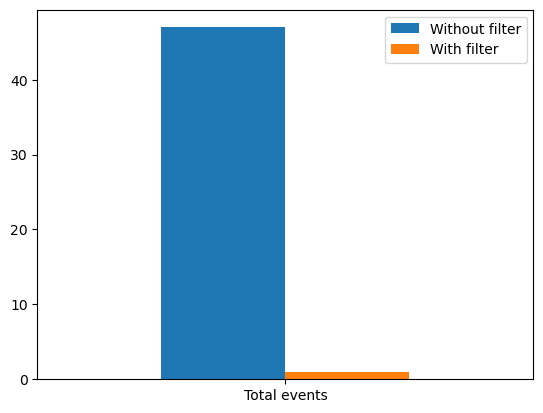

In [5]:
#Print statement
print("When appliying the filters, the number of events in Laos is reduced from " + str(em_dat_raw.query('ISO == "LAO" &  `Disaster Type` in @PROB_COLS').shape[0] )+ " to " 
      + str(em_dat_raw_filtered.query('`ISO` == "LAO" &  `Disaster Type` in @PROB_COLS').shape[0]))

#Graph
obs_effect = pd.DataFrame(columns=["Without filter", "With filter"])
obs_effect.loc["Total events"] = [em_dat_raw.query('ISO == "LAO" &  `Disaster Type` in @PROB_COLS').shape[0], em_dat_raw_filtered.query('`ISO` == "LAO" &  `Disaster Type` in @PROB_COLS').shape[0]]
obs_effect.plot(kind = "bar").set_xticklabels(labels = ["Total events"], rotation = 0);

Now we present how the number of events registered for Laos change as the filter Total_Affected changes:

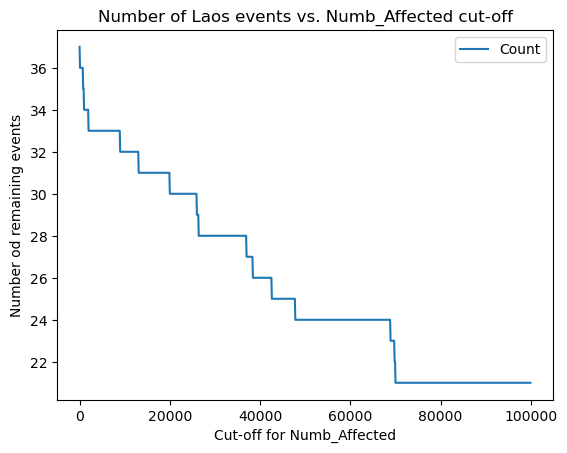

In [6]:
#Creating the count dataframe
count_df = pd.DataFrame()

for x in list(range(0,100000, 100)):
    count_df.loc[x, "Count"] =  em_dat_raw.query('`Numb_Affected` > @x &  `Disaster Type` in @PROB_COLS &  `ISO` == "LAO" ').shape[0]
#Graph
count_df.plot()
plt.xlabel("Cut-off for Numb_Affected")
plt.ylabel("Number od remaining events");
plt.title("Number of Laos events vs. Numb_Affected cut-off");

Now, we present the general behavior of the number of events for Laos as the filter Total_Affected changes:

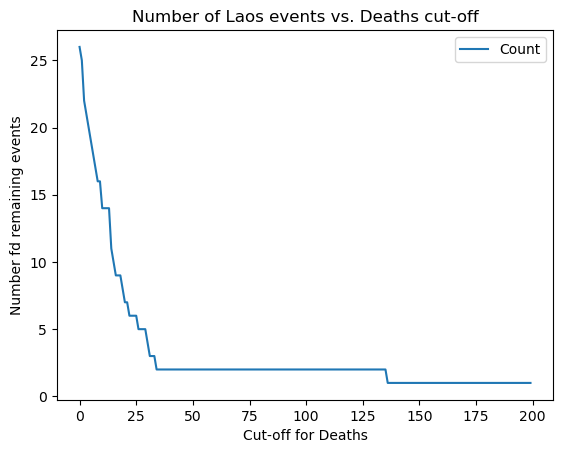

In [7]:
#Creating the count dataframe
count_df = pd.DataFrame()

for x in list(range(0,200, 1)):
    count_df.loc[x, "Count"] =  em_dat_raw.query('`Deaths` > @x &  `Disaster Type` in @PROB_COLS &  `ISO` == "LAO"').shape[0]
#Graph
count_df.plot()
plt.xlabel("Cut-off for Deaths")
plt.ylabel("Number fd remaining events");
plt.title("Number of Laos events vs. Deaths cut-off");

Given the reduced number of events in Laos when the filters are applied and the strong effect of Deaths filter, will use different thresholds to analyze Laos.

We will limit the filters to:
- Start_Year > 1970
- Total_Affected > 1000
- Disasters:  "Drought", "Earthquake", "Extreme temperature", "Flood", "Storm", "Volcanic activity", "Wildfire"

When appliying the adjusted filters, the number of events in Laos is reduced from 47 to 33


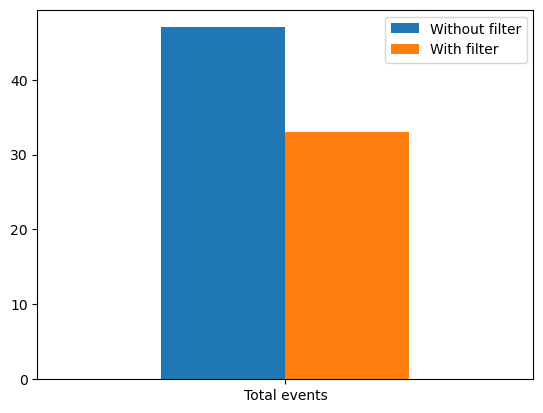

In [8]:
#Print statement
print("When appliying the adjusted filters, the number of events in Laos is reduced from " + str(em_dat_raw.query('ISO == "LAO" &  `Disaster Type` in @PROB_COLS').shape[0] )+ " to "
      + str(em_dat_raw.rename(columns=EM_DAT_COL_DICT
                 ).query("Total_Affected >1000 & Start_Year > 1970 & ISO == 'LAO' & `Disaster Type` in @PROB_COLS ").shape[0]))

#Graph
obs_effect = pd.DataFrame(columns=["Without filter", "With filter"])
obs_effect.loc["Total events Laos"] = [em_dat_raw.query('ISO == "LAO" &  `Disaster Type` in @PROB_COLS').shape[0], em_dat_raw.rename(columns=EM_DAT_COL_DICT
                 ).query("Total_Affected >1000 & Start_Year > 1970 & ISO == 'LAO' & `Disaster Type` in @PROB_COLS ").shape[0]]
obs_effect.plot(kind = "bar").set_xticklabels(labels = ["Total events"], rotation = 0);

In [9]:
#Laos datasets
em_dat_laos_raw = em_dat_raw.rename(columns=EM_DAT_COL_DICT
                 ).query("Total_Affected >1000 & Start_Year > 1970 & ISO == 'LAO' & `Disaster Type` in @PROB_COLS ")

intensity_laos_df = em_dat_laos_raw[INTENSITY_COLS].set_index(["ISO", "Start_Year"]).sort_index()

probability_laos_df = (em_dat_laos_raw.groupby(["Disaster Type", "ISO", "Start_Year", "Region"])
                        .size()
                        .unstack("Disaster Type")
                        .fillna(0)
                        .reset_index()
                        .set_index(["ISO", "Start_Year"])
                        .sort_index())

In the 33 registered disasters, there are only three types of disasters: **Drought, Flood, Storm.**

# 3. Descriptive stats for Laos

In [10]:
#Descriptive statistics Intensity
descriptive_stats_function(df = intensity_laos_df, varlist= intensity_laos_df.describe().columns.values.tolist())

,Deaths,Injured,Numb_Affected,Homeless,Total_Affected,Total_Damage,Total_Damage_Adjusted
count,20.000000,4.000000,3.200000e+01,2.000000,3.300000e+01,10.000000,10.000000
mean,20.850000,68.000000,3.317414e+05,507500.000000,3.524544e+05,46105.000000,59777.000000
std,28.961454,45.173739,6.113195e+05,696500.179469,6.126453e+05,72113.858469,89280.348569
min,1.000000,2.000000,2.000000e+03,15000.000000,2.000000e+03,50.000000,63.000000
25%,5.750000,58.250000,4.648750e+04,261250.000000,4.780000e+04,400.000000,1571.000000
50%,14.500000,84.000000,1.950000e+05,507500.000000,2.000000e+05,6825.000000,10391.000000
75%,23.000000,93.750000,4.225000e+05,753750.000000,4.300000e+05,60750.000000,79459.000000
max,136.000000,102.000000,3.500000e+06,1000000.000000,3.500000e+06,225000.000000,273023.000000
kurtosis,14.587108,2.987263,2.497072e+01,NaN,2.305156e+01,4.176681,3.128777
skewness,3.594094,-1.701630,4.754337e+00,NaN,4.502191e+00,1.992835,1.797345


In [11]:
#Descriptive statistics Probability
descriptive_stats_function(df = probability_laos_df, varlist= probability_laos_df.describe().columns.values.tolist())

,Drought,Flood,Storm
count,26.000000,26.000000,26.000000
mean,0.115385,0.846154,0.307692
std,0.325813,0.612686,0.549125
min,0.000000,0.000000,0.000000
25%,0.000000,0.250000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,1.000000,0.750000
max,1.000000,2.000000,2.000000
kurtosis,4.914934,-0.178482,2.058359
skewness,2.557708,0.080270,1.644545


## 3.1 Event intensity through time

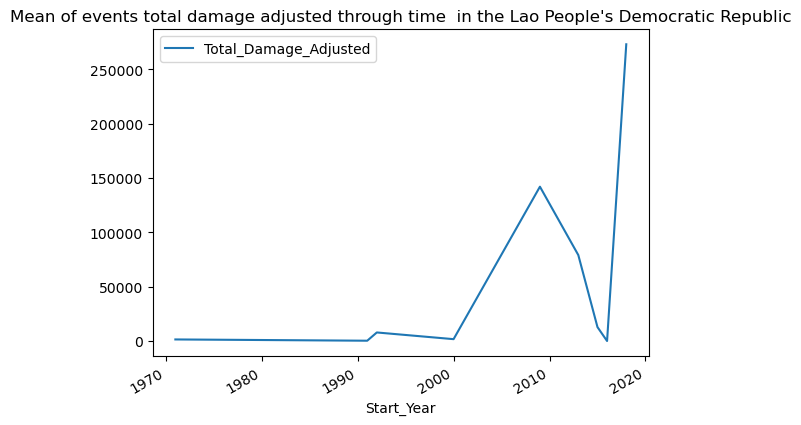

In [12]:
intensity_laos_df.pivot_table(values= "Total_Damage_Adjusted",  index = "Start_Year", 
                                  aggfunc= "mean").plot(title = "Mean of events total damage adjusted through time  in the Lao People's Democratic Republic" );


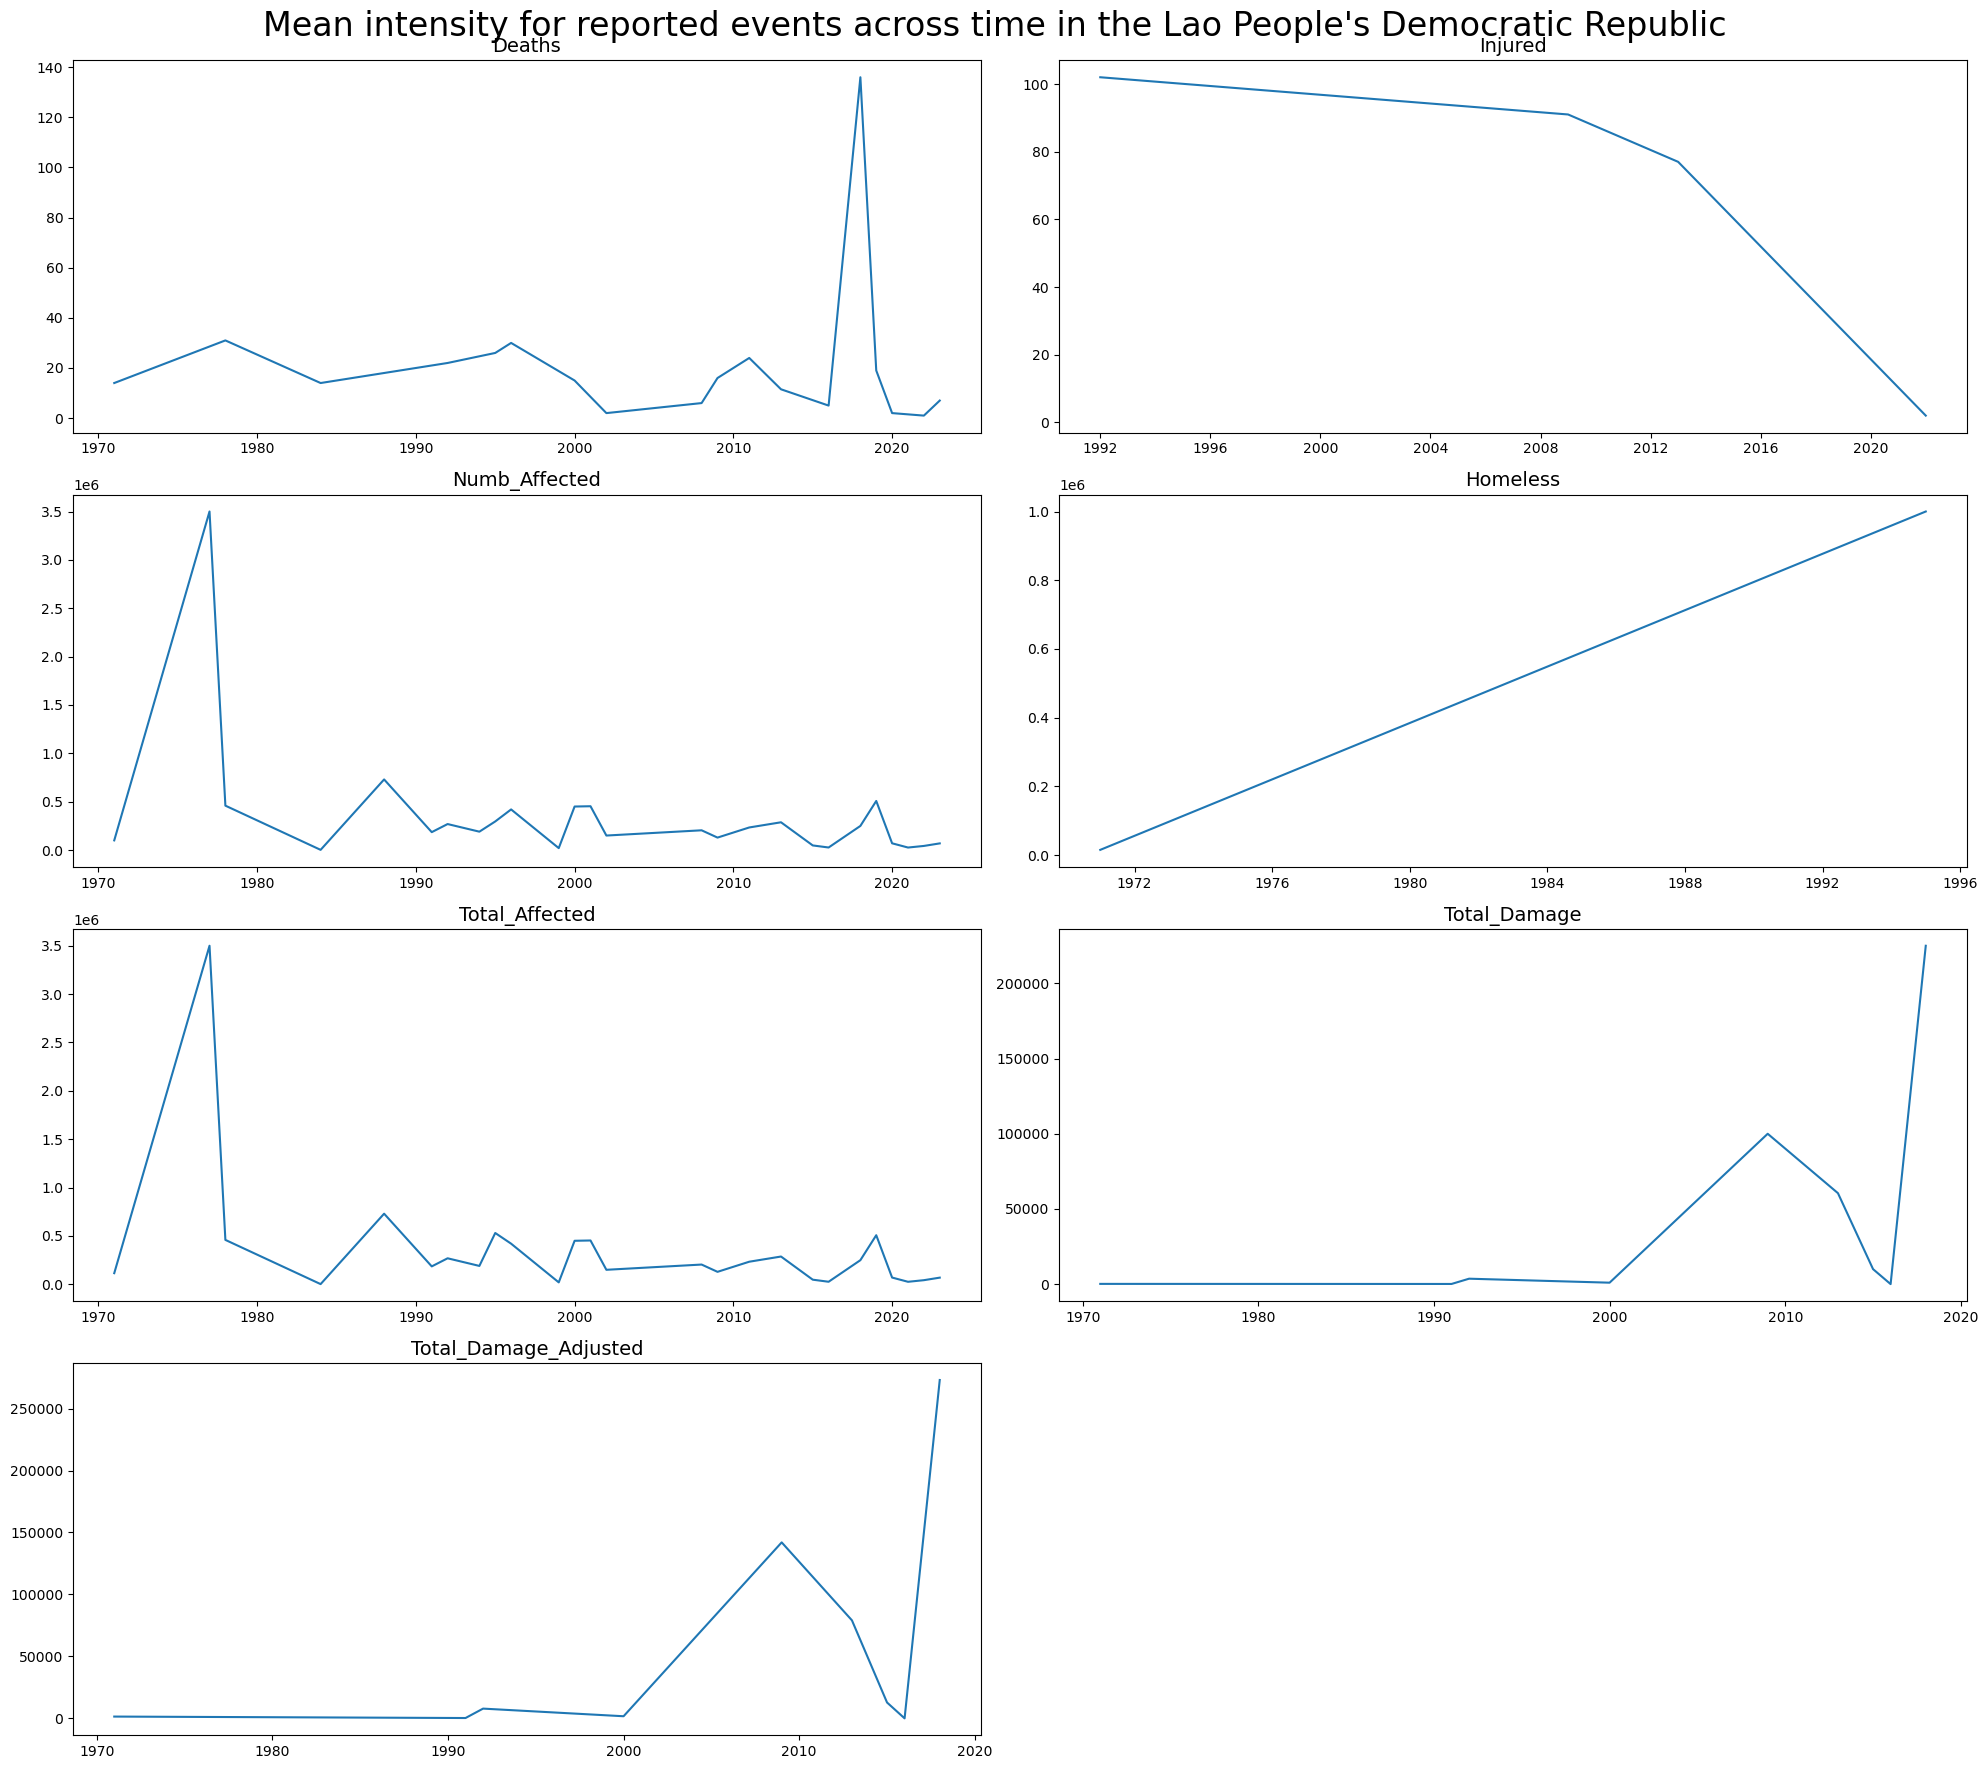

In [13]:
subplots_function( df = intensity_laos_df, var_list = intensity_laos_df.describe().columns.values.tolist(), 
                  index = "Start_Year", aggregation_funct = "mean", graph_rows =4, 
                  figure_size=  (20, 18) ,subplot_title_fontsize= 14, title = "Mean intensity for reported events across time in the Lao People's Democratic Republic")

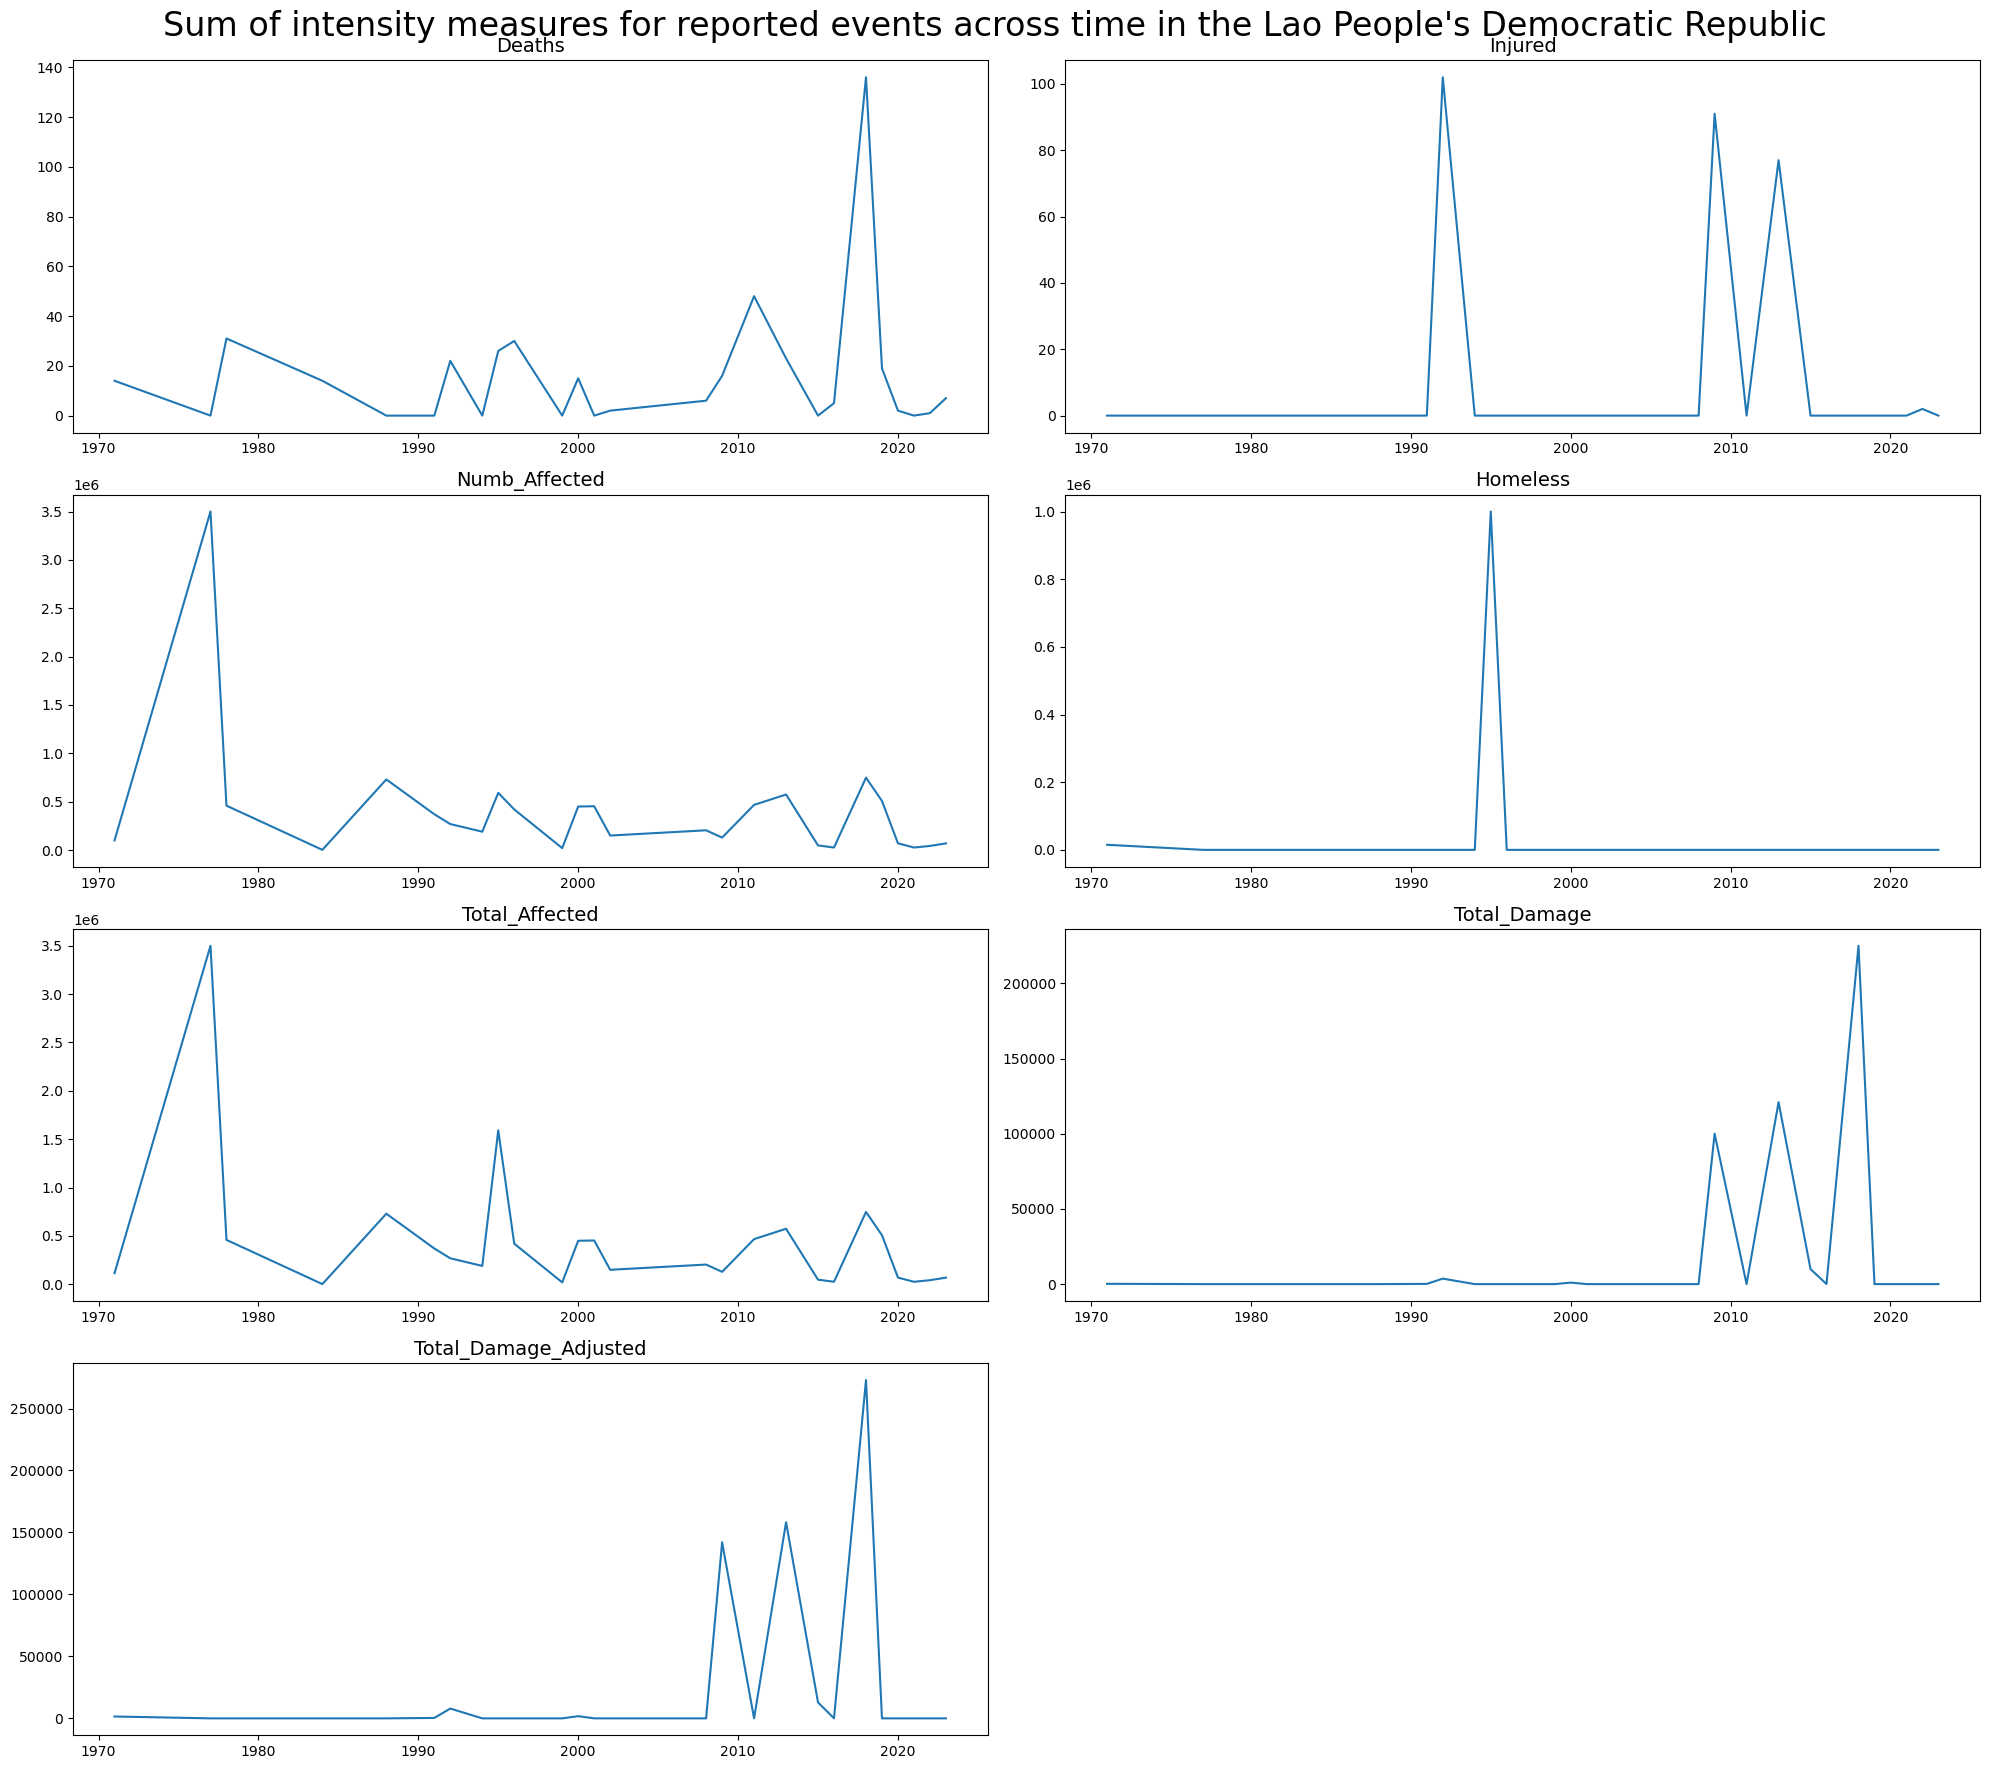

In [14]:
subplots_function( df = intensity_laos_df, var_list = intensity_laos_df.describe().columns.values.tolist(), 
                  index = "Start_Year", aggregation_funct = "sum", graph_rows =4, 
                  figure_size=  (20, 18) ,subplot_title_fontsize= 14, title = "Sum of intensity measures for reported events across time in the Lao People's Democratic Republic")

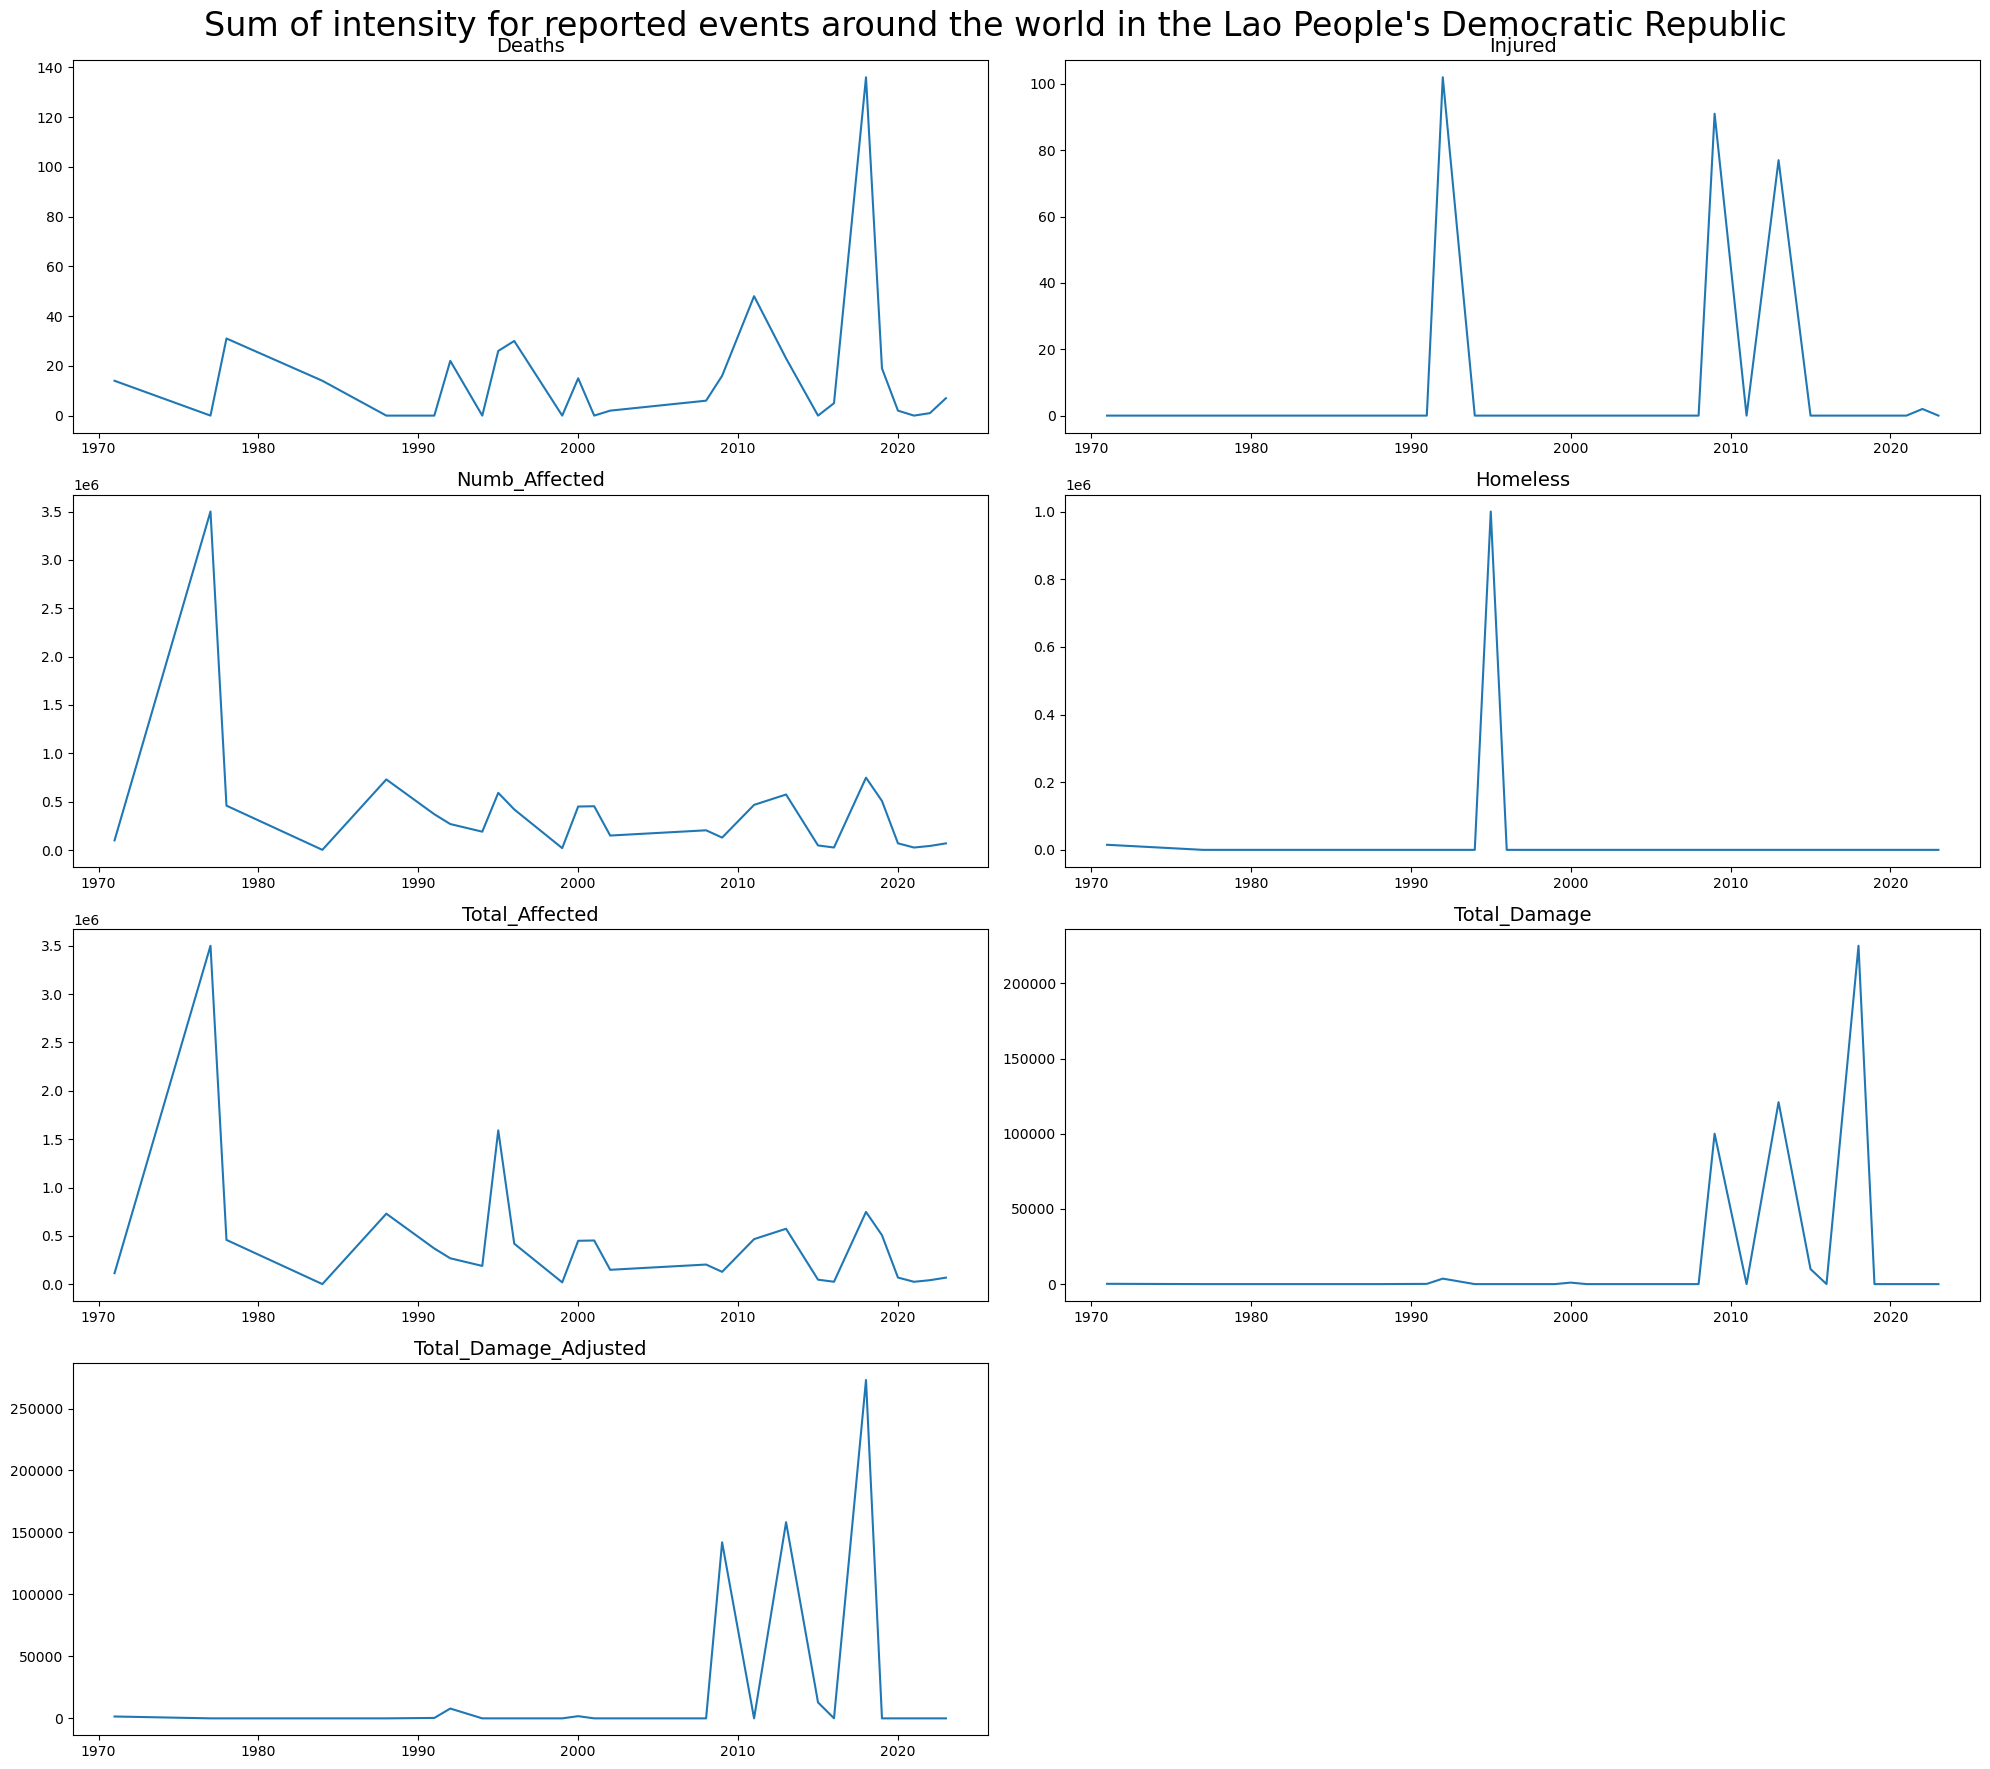

In [15]:
subplots_function( df = intensity_laos_df, var_list = intensity_laos_df.describe().columns.values.tolist(), 
                  index = "Start_Year", aggregation_funct = "sum", graph_rows =4, 
                  figure_size=  (20, 18) ,subplot_title_fontsize= 14, title = "Sum of intensity for reported events around the world in the Lao People's Democratic Republic")

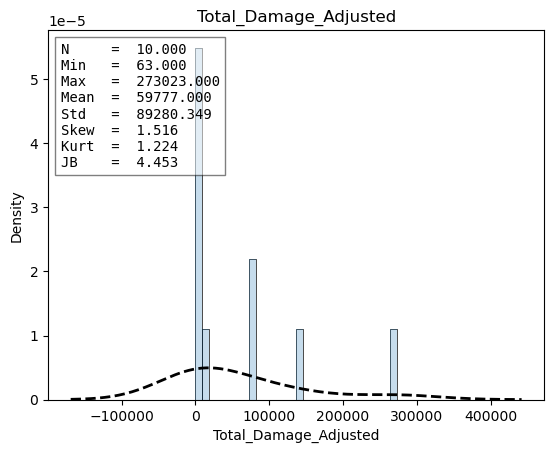

In [16]:
#Histogram and Kernel density for  total damage adjusted
_plot_single_kde(data =intensity_laos_df["Total_Damage_Adjusted"]);

## 3.2 Number of events through time

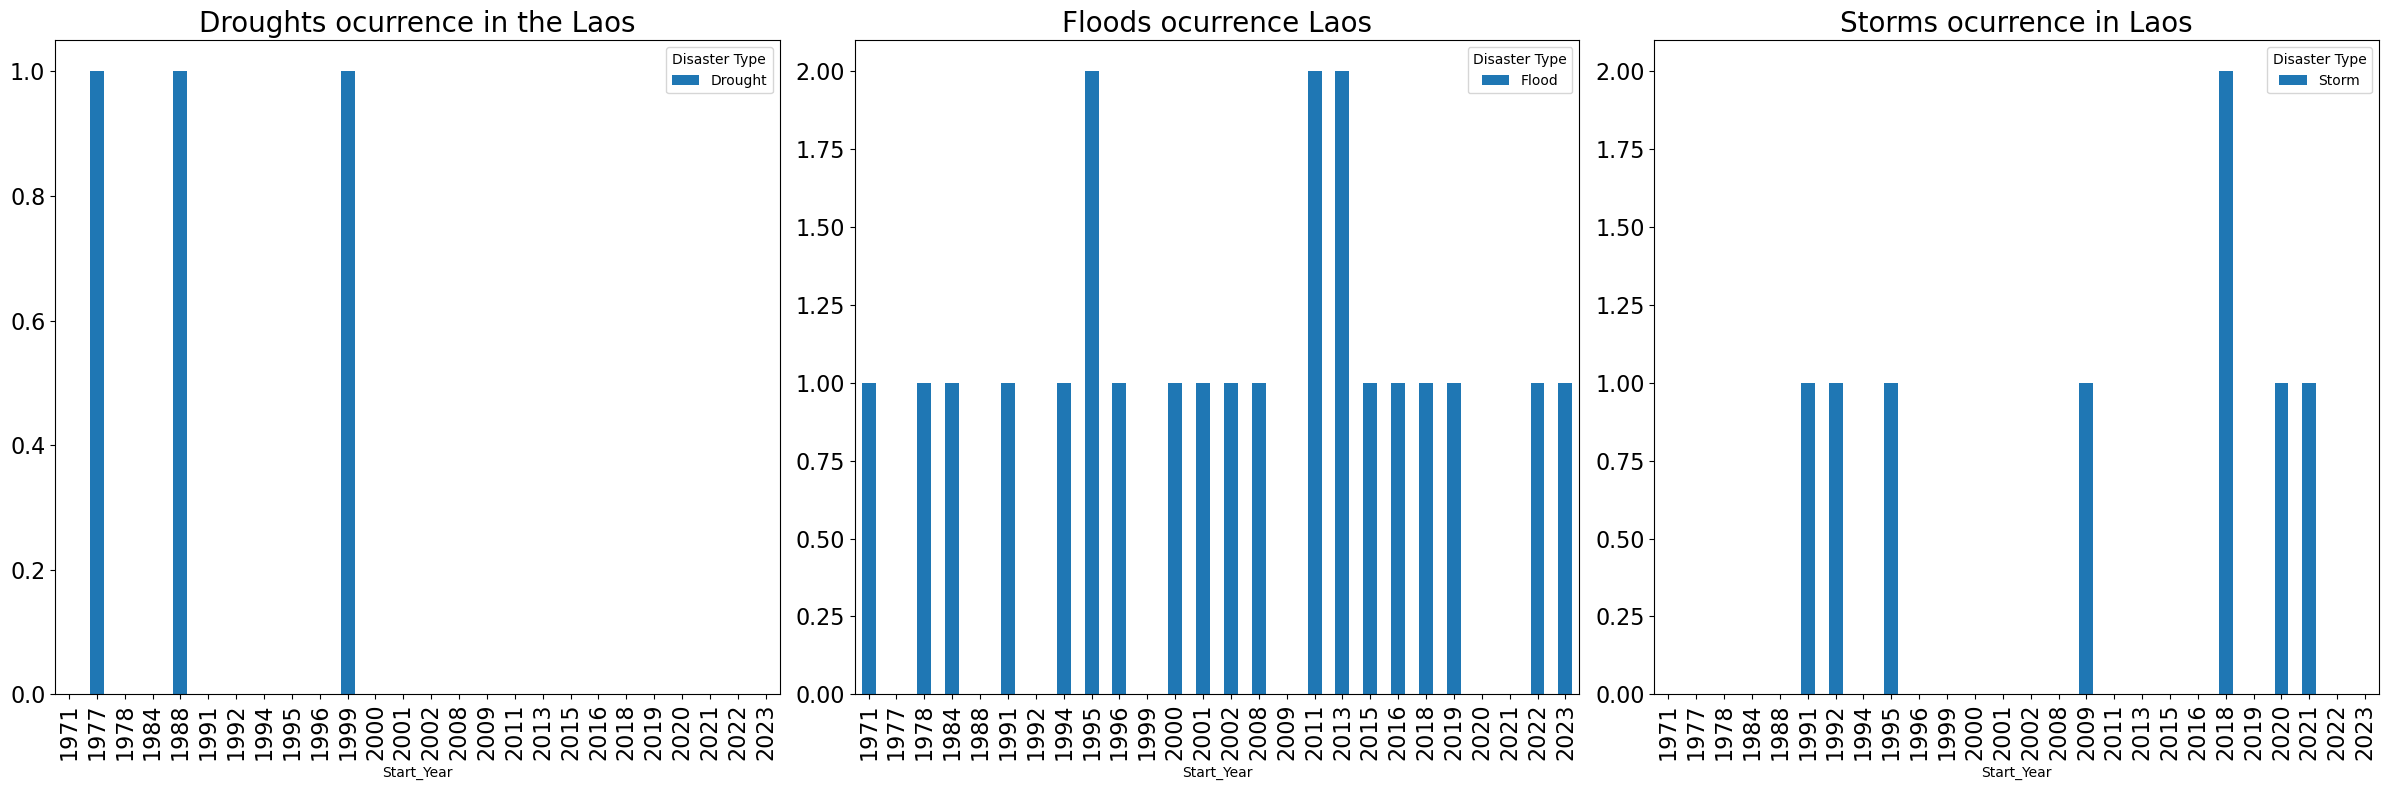

In [17]:
from matplotlib.dates import DateFormatter

fig, axes = plt.subplots(figsize=(24,8),nrows=1, ncols=3)


probability_laos_df.pivot_table( values= "Drought",  index = "Start_Year", 
                                  aggfunc= "sum").plot(ax=axes[0], kind = "bar");
axes[0].set_title(label = "Droughts ocurrence in the Laos", fontsize= 20)
axes[0].tick_params(axis='both',  labelsize= 16)


probability_laos_df.pivot_table( values= "Flood",  index = "Start_Year", 
                                  aggfunc= "sum").plot(ax=axes[1], kind = "bar");
axes[1].tick_params(axis='both',  labelsize= 16)
axes[1].set_title(label = "Floods ocurrence Laos", fontsize= 20 )

probability_laos_df.pivot_table( values= "Storm",  index = "Start_Year", 
                                  aggfunc= "sum").plot(ax=axes[2], kind = "bar")

axes[2].set_title(label = "Storms ocurrence in Laos", fontsize= 20)
axes[2].tick_params(axis='both',  labelsize= 16);

for axis in axes:
    ticks = [tick.get_text() for tick in axis.get_xticklabels()]
    ticks = pd.to_datetime(ticks).strftime('%Y')
    axis.set_xticklabels(ticks)
    
plt.tight_layout()